<a href="https://colab.research.google.com/github/faheemkhaskheli9/Deep-Learning-Basic-Keras/blob/main/Basic_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is taken from keras Example Codes


# Connect Google Drive to colab to save and load files from GDrive if needed


In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
%cd '/gdrive/My Drive/'

Mounted at /gdrive/
/gdrive/My Drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the data: the Cats vs Dogs dataset

In [ ]:
# First, let's download the 786M ZIP archive of the raw data:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  62.7M      0  0:00:12  0:00:12 --:--:-- 61.5M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip

In [ ]:
# This Dataset Contain 2 Folders, 1 for Dog and 1 For Cat

In [ ]:
import os # needed for getting the list of files and folder in our dataset folder

num_skipped = 0 # used to count number of skipped images, here if not .jfif
for folder_name in os.listdir("PetImages"): # get names of all folder in PetImages
    folder_path = os.path.join("PetImages", folder_name) # combine base folder and inside folder to make vail path
    # example PetImages/Cat or PetImages/Dog
    # you can print folder_path to see the values it contain
    #print(folder_path)
    for fname in os.listdir(folder_path): # get names of all file or folder inside cat and dog folder
        fpath = os.path.join(folder_path, fname) # same as above used to make valid path

        try:
            fobj = open(fpath, "rb") # read file as binary
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # check if it is jfif file
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1 # increase counter by 1 for each file
            # Delete corrupted image
            os.remove(fpath) # delete if it is not  jfif file

print("Deleted %d images" % num_skipped)

Deleted 1561 images


# Generate a Dataset

In [ ]:
image_size = (180, 180) # size of image, it will resize image if it is big or small
batch_size = 32 # batch size for Model to train on

# generate training images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# generate validation images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


In [ ]:
# Cat = 0
# Dog = 1

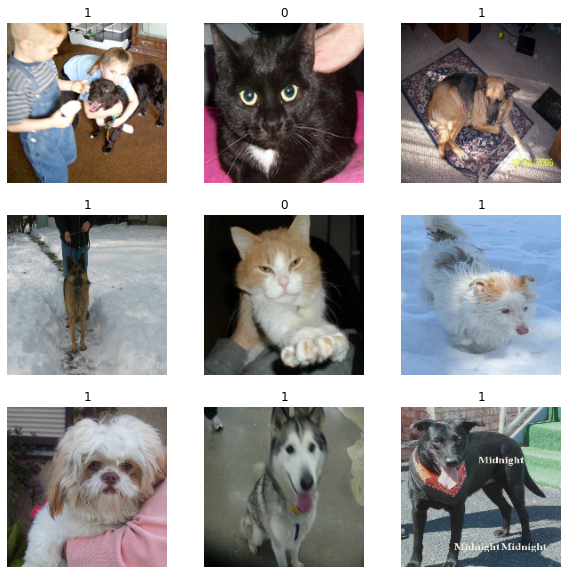

In [ ]:
import matplotlib.pyplot as plt # plot for viewing images

plt.figure(figsize=(10, 10)) # figure height and Width (10,10)
for images, labels in train_ds.take(1):
    for i in range(9):  # loop for 9 images
        ax = plt.subplot(3, 3, i + 1) # 3 by 3 sub plot

        plt.imshow(images[i].numpy().astype("uint8")) # convert image array to 8 bit unsiged integer
        # uint 8 is a type to see image in pixel value of 0 to 255

        plt.title(int(labels[i])) # show label and title of plot, either 0 or 1
        plt.axis("off") # hide x and y axis

# Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

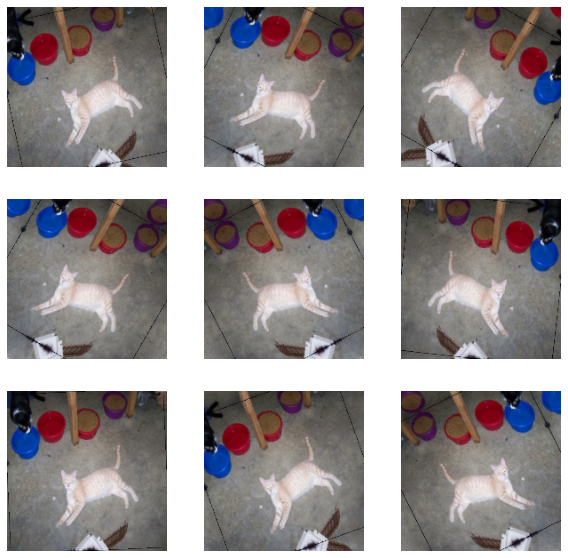

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images) # here above Data augmentation function is used
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.



# Two options to preprocess the data

There are two ways you could be using the data_augmentation preprocessor:

Option 1: Make it part of the model, like this:

In [ ]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs) # data augmentation function is called here
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this is the better option.

Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.

# Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

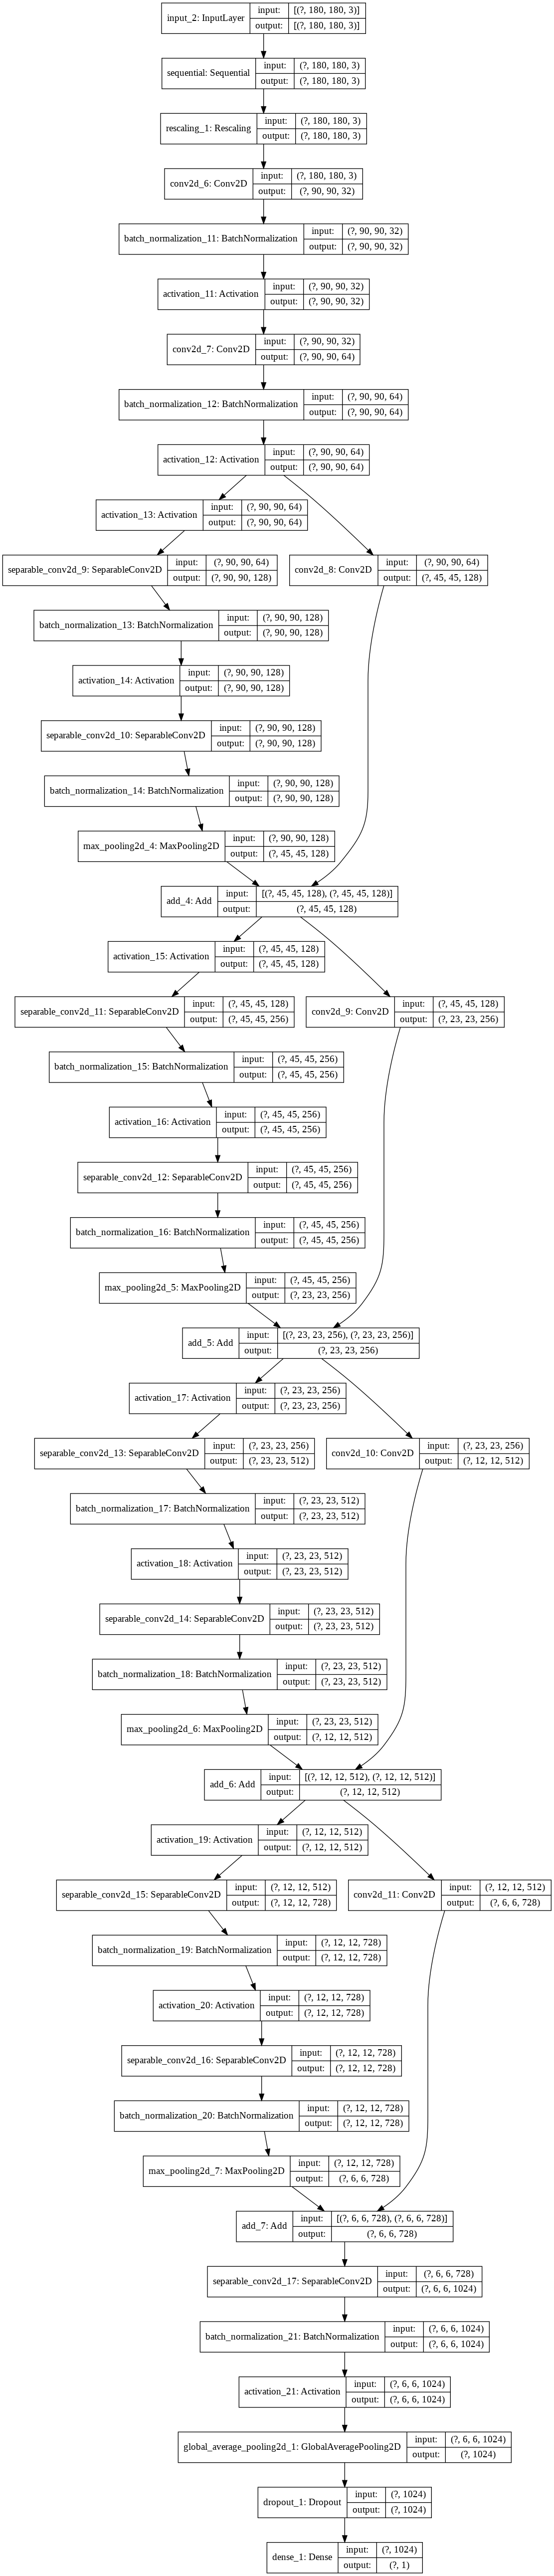

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape) # input layer
    # need input image shape, which is defined above in the start

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) # rescale dataset
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # convoltional layer
    x = layers.BatchNormalization()(x) #
    x = layers.Activation("relu")(x) # relu activation, used when we have lots of layers
    # dont use signmoid or tanh here

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dont use signmoid or tanh here

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    # you can use signmoid at the last layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# This my model much simpler

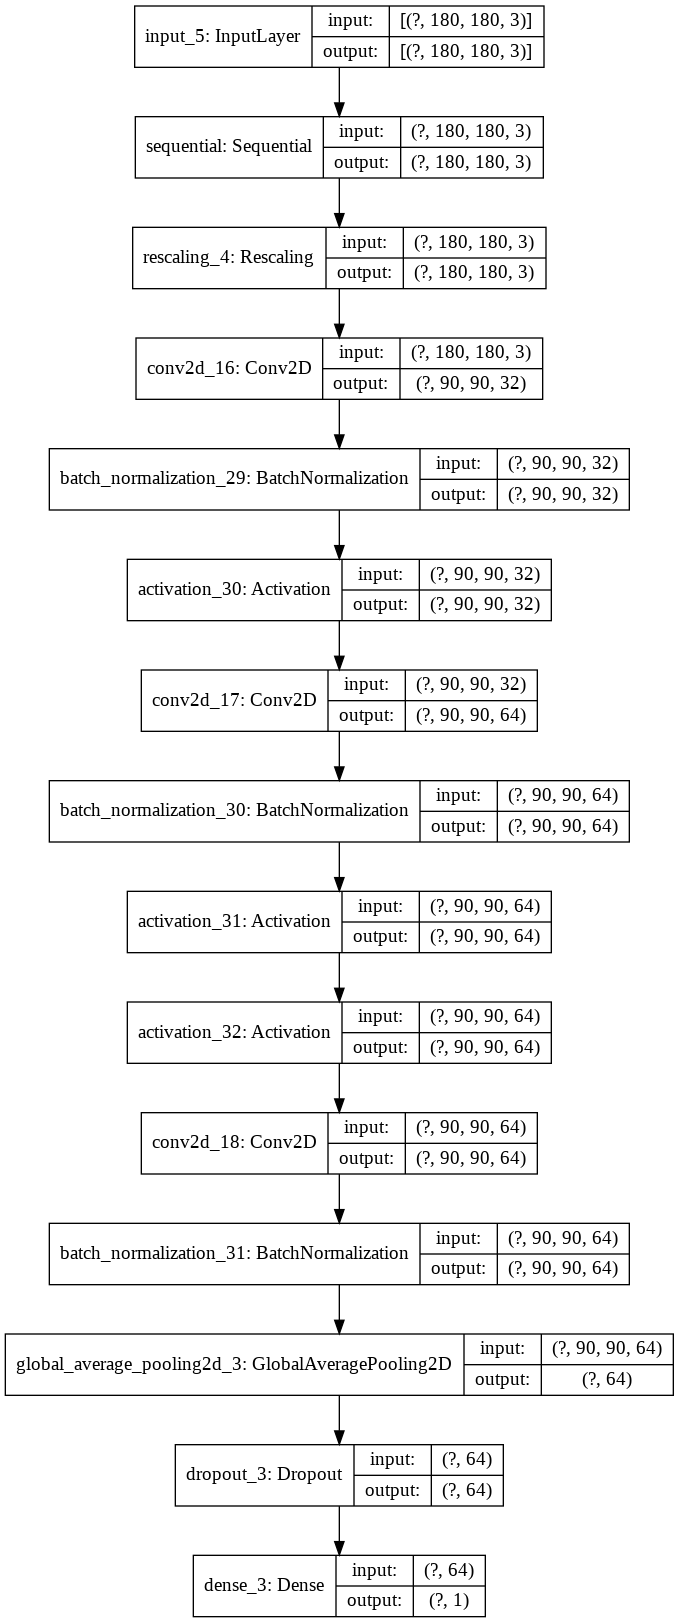

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape) # input layer
    # need input image shape, which is defined above in the start

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) # rescale dataset
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # convoltional layer
    x = layers.BatchNormalization()(x) #
    x = layers.Activation("relu")(x) # relu activation, used when we have lots of layers
    # dont use signmoid or tanh here

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dont use signmoid or tanh here

    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    # you can use signmoid at the last layer
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50 # number of time whole dataset is train

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
# callback save model during training

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
# binary_crossentropy is used because we have 2 classes, cat and dog
# accuracy is used to see how many images are predicted correctly

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 1734s 3s/step - loss: 0.6880 - accuracy: 0.5855 - val_loss: 0.7045 - val_accuracy: 0.5712
Epoch 2/50
586/586 [==============================] - 1727s 3s/step - loss: 0.6538 - accuracy: 0.6137 - val_loss: 0.7235 - val_accuracy: 0.5353
Epoch 3/50
586/586 [==============================] - 1725s 3s/step - loss: 0.6412 - accuracy: 0.6266 - val_loss: 0.6738 - val_accuracy: 0.5622
Epoch 4/50
586/586 [==============================] - 1720s 3s/step - loss: 0.6264 - accuracy: 0.6457 - val_loss: 1.4628 - val_accuracy: 0.5103
Epoch 5/50
 30/586 [>.............................] - ETA: 25:13 - loss: 0.5982 - accuracy: 0.6729